In [905]:
import ast
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, wasserstein_distance
from pandas.api.types import CategoricalDtype

%matplotlib inline

In [906]:
sns.set_theme(context='notebook', style='ticks', font_scale=1.25)

# color_palette = ["#7FB069", "#414288", "#A8E0FF"]
# color_palette = ["#55B475", "#006992", "#9A879D"]
# color_palette = ["#6BC7AB", "#0062A3", "#00A6ED"]
# color_palette = ['#00429d', '#63b6cc', '#00dba1']
# color_palette = ["#00A6ED", "#E07F00", "#F6AA28"]
color_palette = ["#00A6ED", "#FF9E1F", "#E75E4B"]
sns.set_palette(color_palette)

In [907]:
EXPERIMENT_ID = "run-2023-01-31-23-30"

FILE_STIMULI = os.path.join("../", "prompting", "data", "stimuli_v1.csv")
FILE_CODEX_RESULTS = os.path.join("../", "experiments", EXPERIMENT_ID, "codex", "results.csv")
FILE_SIMULATOR_RESULTS = os.path.join("../", "experiments", EXPERIMENT_ID, "webppl", "simulator_results.csv")
FILE_HUMAN_DATA = os.path.join("human_data_full.csv")
FILE_BASELINE_ZEROSHOT = os.path.join("../", "codex-baseline", "codex_baseline_v1_zeroshot_code-davinci-002_results.csv")
FILE_BASELINE_FEWSHOT = os.path.join("../", "codex-baseline", "codex_baseline_v1_fewshot_code-davinci-002_results.csv")

In [908]:
df_stimuli = pd.read_csv(FILE_STIMULI, keep_default_na=False)
df_codex = pd.read_csv(FILE_CODEX_RESULTS, keep_default_na=False)
df_simulator = pd.read_csv(FILE_SIMULATOR_RESULTS, keep_default_na=False)

df_human = pd.read_csv(FILE_HUMAN_DATA, keep_default_na=False)
df_human.index = df_human.index.astype(int)
df_human = df_human.rename(axis="columns", mapper={"response": "likert_human", "run_id": "participant_id"})

df_baseline_zeroshot = pd.read_csv(FILE_BASELINE_ZEROSHOT, keep_default_na=False)
df_baseline_zeroshot["probs"] = df_baseline_zeroshot["probs"].apply(ast.literal_eval)

df_baseline_fewshot = pd.read_csv(FILE_BASELINE_FEWSHOT, keep_default_na=False)
df_baseline_fewshot["probs"] = df_baseline_fewshot["probs"].apply(ast.literal_eval)

In [909]:
df_human_tall = df_human[["task_id", "participant_id", "likert_human"]].copy()
df_human_tall["participant_id"] = [f"human_{pid:03}" for pid in df_human_tall["participant_id"]]
df_human_tall["source"] = "human"
df_human_tall = df_human_tall[["source", "task_id", "participant_id", "likert_human"]].sort_values(["task_id", "participant_id"])
df_human_tall

,source,task_id,participant_id,likert_human
32,human,1,human_003,1
64,human,1,human_005,5
160,human,1,human_012,2
176,human,1,human_013,2
272,human,1,human_020,2
...,...,...,...,...
2191,human,64,human_153,3
2271,human,64,human_158,3
2335,human,64,human_162,2
2383,human,64,human_165,3


In [910]:
N_PSEUDOPARTICIPANTS = 40
data = []

for _, row in df_simulator.iterrows():
    if not row["probs"]:
        raise ValueError(f"WARNING: No results for task_id {task_id}")
    
    probs = ast.literal_eval(row["probs"])
    support = ast.literal_eval(row["support"])
    
    for p, v in zip(probs, support):
        for _ in range(round(N_PSEUDOPARTICIPANTS * p)):
            data.append({
                "task_id": row["task_id"],
                "likert_model": v,
                # "example_answer": row["example_answer"]
            })
            
df_simulator_tall = pd.DataFrame(data)
df_simulator_tall["source"] = "PiLoT (ours)"
df_simulator_tall["participant_id"] = "simulator_000"
df_simulator_tall = df_simulator_tall[["source", "task_id", "participant_id", "likert_model"]].sort_values(["task_id", "participant_id"])
df_simulator_tall

,source,task_id,participant_id,likert_model
0,PiLoT (ours),1,simulator_000,1
1,PiLoT (ours),1,simulator_000,1
2,PiLoT (ours),1,simulator_000,1
3,PiLoT (ours),1,simulator_000,1
4,PiLoT (ours),1,simulator_000,1
...,...,...,...,...
2555,PiLoT (ours),64,simulator_000,4
2556,PiLoT (ours),64,simulator_000,4
2557,PiLoT (ours),64,simulator_000,4
2558,PiLoT (ours),64,simulator_000,4


In [911]:
df_simulator_err = df_simulator_tall.groupby("task_id").sem().rename({"likert_model": "Model error"}, axis=1)
df_simulator_err

/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_24693/3661895852.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_simulator_err = df_simulator_tall.groupby("task_id").sem().rename({"likert_model": "Model error"}, axis=1)


,Model error
task_id,
1,0.106217
2,0.118687
3,0.138444
4,0.144115
5,0.131009
...,...
60,0.161672
61,0.091199
62,0.078446


## Error bars

In [912]:
df_model_tall.groupby("task_id")

In [913]:
def transform_probs_to_likert(probs):
    return np.dot(probs, np.array([1, 2, 3, 4, 5, 6, 7]))

df_baseline_zeroshot_tall["likert_model"] = df_baseline_zeroshot["probs"].apply(transform_probs_to_likert)
df_baseline_fewshot_tall["likert_model"] = df_baseline_fewshot["probs"].apply(transform_probs_to_likert)

df_baseline_zeroshot_tall["participant_id"] = "baseline_zeroshot_000"
df_baseline_fewshot_tall["participant_id"] = "baseline_fewshot_000"

df_baseline_zeroshot_tall["source"] = "Baseline (zero-shot)"
df_baseline_fewshot_tall["source"] = "Baseline (few-shot)"

df_baseline_zeroshot_tall = df_baseline_zeroshot_tall[["source", "task_id", "participant_id", "likert_model"]].sort_values(["task_id", "participant_id"])
df_baseline_fewshot_tall = df_baseline_fewshot_tall[["source", "task_id", "participant_id", "likert_model"]].sort_values(["task_id", "participant_id"])

In [914]:
df_baseline_zeroshot_tall

,source,task_id,participant_id,likert_model
0,Baseline (zero-shot),1,baseline_zeroshot_000,3.162319
1,Baseline (zero-shot),2,baseline_zeroshot_000,3.766570
2,Baseline (zero-shot),3,baseline_zeroshot_000,3.376271
3,Baseline (zero-shot),4,baseline_zeroshot_000,3.771069
4,Baseline (zero-shot),5,baseline_zeroshot_000,3.597263
...,...,...,...,...
59,Baseline (zero-shot),60,baseline_zeroshot_000,3.212380
60,Baseline (zero-shot),61,baseline_zeroshot_000,4.008362
61,Baseline (zero-shot),62,baseline_zeroshot_000,3.873004
62,Baseline (zero-shot),63,baseline_zeroshot_000,3.709788


In [915]:
df_baseline_fewshot_tall

,source,task_id,participant_id,likert_model
0,Baseline (few-shot),1,baseline_fewshot_000,3.576526
1,Baseline (few-shot),2,baseline_fewshot_000,3.885004
2,Baseline (few-shot),3,baseline_fewshot_000,3.872588
3,Baseline (few-shot),4,baseline_fewshot_000,4.139216
4,Baseline (few-shot),5,baseline_fewshot_000,3.623616
...,...,...,...,...
59,Baseline (few-shot),60,baseline_fewshot_000,2.998969
60,Baseline (few-shot),61,baseline_fewshot_000,3.858325
61,Baseline (few-shot),62,baseline_fewshot_000,4.258780
62,Baseline (few-shot),63,baseline_fewshot_000,4.021730


## Merge

In [916]:
df_model_tall = pd.concat([df_simulator_tall, df_baseline_zeroshot_tall, df_baseline_fewshot_tall]).reset_index(drop=True).groupby(["task_id", "source"]).mean().reset_index()
df_model_tall

/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_24693/1819788326.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_model_tall = pd.concat([df_simulator_tall, df_baseline_zeroshot_tall, df_baseline_fewshot_tall]).reset_index(drop=True).groupby(["task_id", "source"]).mean().reset_index()


,task_id,source,likert_model
0,1,Baseline (few-shot),3.576526
1,1,Baseline (zero-shot),3.162319
2,1,PiLoT (ours),1.900000
3,2,Baseline (few-shot),3.885004
4,2,Baseline (zero-shot),3.766570
...,...,...,...
187,63,Baseline (zero-shot),3.709788
188,63,PiLoT (ours),5.475000
189,64,Baseline (few-shot),3.826373
190,64,Baseline (zero-shot),3.599477


In [917]:
model_order = CategoricalDtype(
    ['PiLoT (ours)', 'Baseline (few-shot)', 'Baseline (zero-shot)'], 
    ordered=True
)

In [918]:
df_comparison_human_model = df_model_tall.join(df_human_tall.groupby("task_id").mean(), on="task_id")
df_comparison_human_model = df_comparison_human_model.rename({"source": "model", "likert_human": "Human rating (Likert)", "likert_model": "Model rating (Likert)"}, axis=1)
df_comparison_human_model["model"] = df_comparison_human_model["model"].astype(model_order)
df_comparison_human_model = df_comparison_human_model.sort_values(["task_id", "model"], ascending=[True, True]).reset_index(drop=True)

# Add human error
df_comparison_human_model = df_comparison_human_model.join(df_human_tall.groupby("task_id").sem().rename({"likert_human": "Human error"}, axis=1), on="task_id")

df_comparison_human_model

/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_24693/2960136182.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_comparison_human_model = df_model_tall.join(df_human_tall.groupby("task_id").mean(), on="task_id")
/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_24693/2960136182.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_comparison_human_model = df_comparison_human_model.join(df_human_tall.groupby("task_id").sem().rename({"likert_human": "Human error"}, axis=1), on="task_id")


,task_id,model,Model rating (Likert),Human rating (Likert),Human error
0,1,PiLoT (ours),1.900000,1.952381,0.117822
1,1,Baseline (few-shot),3.576526,1.952381,0.117822
2,1,Baseline (zero-shot),3.162319,1.952381,0.117822
3,2,PiLoT (ours),5.525000,5.400000,0.133012
4,2,Baseline (few-shot),3.885004,5.400000,0.133012
...,...,...,...,...,...
187,63,Baseline (few-shot),4.021730,5.250000,0.166987
188,63,Baseline (zero-shot),3.709788,5.250000,0.166987
189,64,PiLoT (ours),2.725000,2.595238,0.152637
190,64,Baseline (few-shot),3.826373,2.595238,0.152637


In [919]:
df_comparison_human_simulator

,model,Model rating (Likert),Human rating (Likert),Human error,Model error
task_id,,,,,
1,PiLoT (ours),1.900,1.952381,0.117822,0.106217
2,PiLoT (ours),5.525,5.400000,0.133012,0.118687
3,PiLoT (ours),3.950,4.026316,0.026316,0.138444
4,PiLoT (ours),4.200,3.475000,0.164034,0.144115
5,PiLoT (ours),4.325,3.975000,0.043670,0.131009
...,...,...,...,...,...
60,PiLoT (ours),4.675,4.547619,0.174449,0.161672
61,PiLoT (ours),6.225,5.605263,0.153385,0.091199
62,PiLoT (ours),6.600,6.250000,0.163103,0.078446


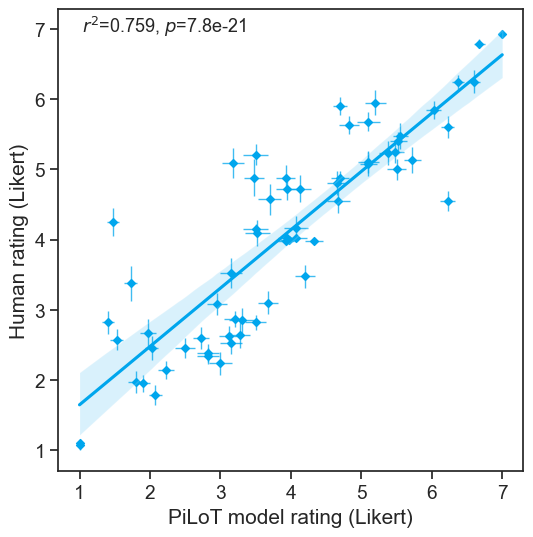

In [939]:
df_comparison_human_simulator = df_comparison_human_model[df_comparison_human_model["model"] == "PiLoT (ours)"].set_index("task_id")

# Add model error
df_comparison_human_simulator = df_comparison_human_simulator.join(df_simulator_err)

plt.figure(figsize=(6, 6))

ax = sns.regplot(data=df_comparison_human_simulator, x="Model rating (Likert)", y="Human rating (Likert)", marker="D", scatter_kws={'alpha': 1.0, 's': 16.0})
# ax.set(xlim=(1,7), ylim=(1, 7))

r, p = pearsonr(df_comparison_human_simulator['Model rating (Likert)'].tolist(), df_comparison_human_simulator['Human rating (Likert)'].tolist())

ax.text(.05, 0.95, r'$r^2$={:.3f}, $p$={:.2g}'.format(r ** 2, p), transform=ax.transAxes, fontsize=13)

ax.errorbar(x=df_comparison_human_simulator["Model rating (Likert)"], 
            y=df_comparison_human_simulator["Human rating (Likert)"],
            xerr=df_comparison_human_simulator["Model error"],
            yerr=df_comparison_human_simulator["Human error"],
            fmt="none",
            zorder=-1,
            # ecolor="lightgray"
            elinewidth=1.0,
            alpha=0.75,
           )


plt.xlabel("PiLoT model rating (Likert)")
plt.savefig("human_simulator_comparison.png", dpi=300, bbox_inches="tight")

/opt/anaconda3/envs/physlang/lib/python3.9/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/physlang/lib/python3.9/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


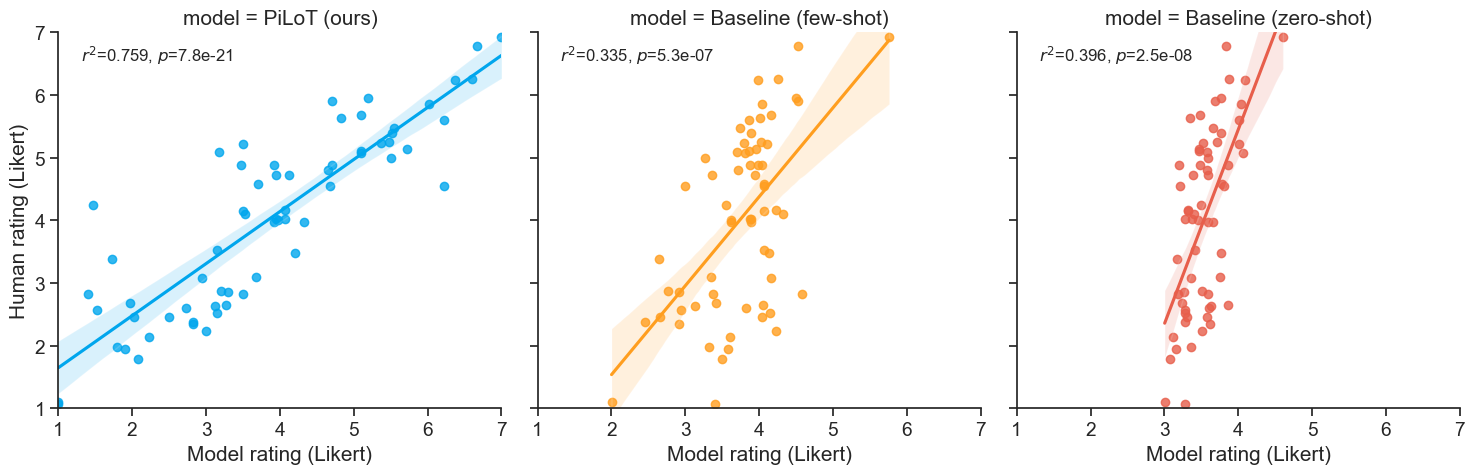

In [921]:
g = sns.lmplot(data=df_comparison_human_model, x="Model rating (Likert)", y="Human rating (Likert)", col="model", sharex=False, sharey=True, hue="model")
g.set(xlim=(1,7), ylim=(1, 7))

def annotate(data, **kws):
    r, p = pearsonr(data['Model rating (Likert)'].tolist(), data['Human rating (Likert)'].tolist())
    ax = plt.gca()
    ax.text(.05, 0.925, r'$r^2$={:.3f}, $p$={:.2g}'.format(r ** 2, p),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")

## Facet analysis

In [922]:
df_facets = df_comparison_human_model.set_index("task_id").join(df_stimuli[["task_id", "complexity", "number", "location", "quant_or_neg", "vague_adj"]].set_index("task_id"))
df_facets["complexity"] = df_facets["complexity"].replace({"low": "Easy", "medium": "Moderate", "high": "Challenging"})
df_facets

,model,Model rating (Likert),Human rating (Likert),Human error,complexity,number,location,quant_or_neg,vague_adj
task_id,,,,,,,,,
1,PiLoT (ours),1.900000,1.952381,0.117822,Easy,1,,,
1,Baseline (few-shot),3.576526,1.952381,0.117822,Easy,1,,,
1,Baseline (zero-shot),3.162319,1.952381,0.117822,Easy,1,,,
2,PiLoT (ours),5.525000,5.400000,0.133012,Easy,1,,,
2,Baseline (few-shot),3.885004,5.400000,0.133012,Easy,1,,,
...,...,...,...,...,...,...,...,...,...
63,Baseline (few-shot),4.021730,5.250000,0.166987,Challenging,1,1,2,1
63,Baseline (zero-shot),3.709788,5.250000,0.166987,Challenging,1,1,2,1
64,PiLoT (ours),2.725000,2.595238,0.152637,Challenging,1,1,2,1


In [923]:
df_wasserstein = pd.read_csv("wasserstein_by_model.csv", index_col="task_id")
df_wasserstein = df_wasserstein.melt(var_name="model", value_name="wasserstein", ignore_index=False)

In [924]:
df_facets = df_facets.merge(df_wasserstein, on=["task_id", "model"])
df_facets

,model,Model rating (Likert),Human rating (Likert),Human error,complexity,number,location,quant_or_neg,vague_adj,wasserstein
task_id,,,,,,,,,,
1,PiLoT (ours),1.900000,1.952381,0.117822,Easy,1,,,,0.054422
1,Baseline (few-shot),3.576526,1.952381,0.117822,Easy,1,,,,1.749028
1,Baseline (zero-shot),3.162319,1.952381,0.117822,Easy,1,,,,1.662859
2,PiLoT (ours),5.525000,5.400000,0.133012,Easy,1,,,,0.182653
2,Baseline (few-shot),3.885004,5.400000,0.133012,Easy,1,,,,1.535303
...,...,...,...,...,...,...,...,...,...,...
63,Baseline (few-shot),4.021730,5.250000,0.166987,Challenging,1,1,2,1,1.396941
63,Baseline (zero-shot),3.709788,5.250000,0.166987,Challenging,1,1,2,1,1.833034
64,PiLoT (ours),2.725000,2.595238,0.152637,Challenging,1,1,2,1,0.253333


/opt/anaconda3/envs/physlang/lib/python3.9/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/physlang/lib/python3.9/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


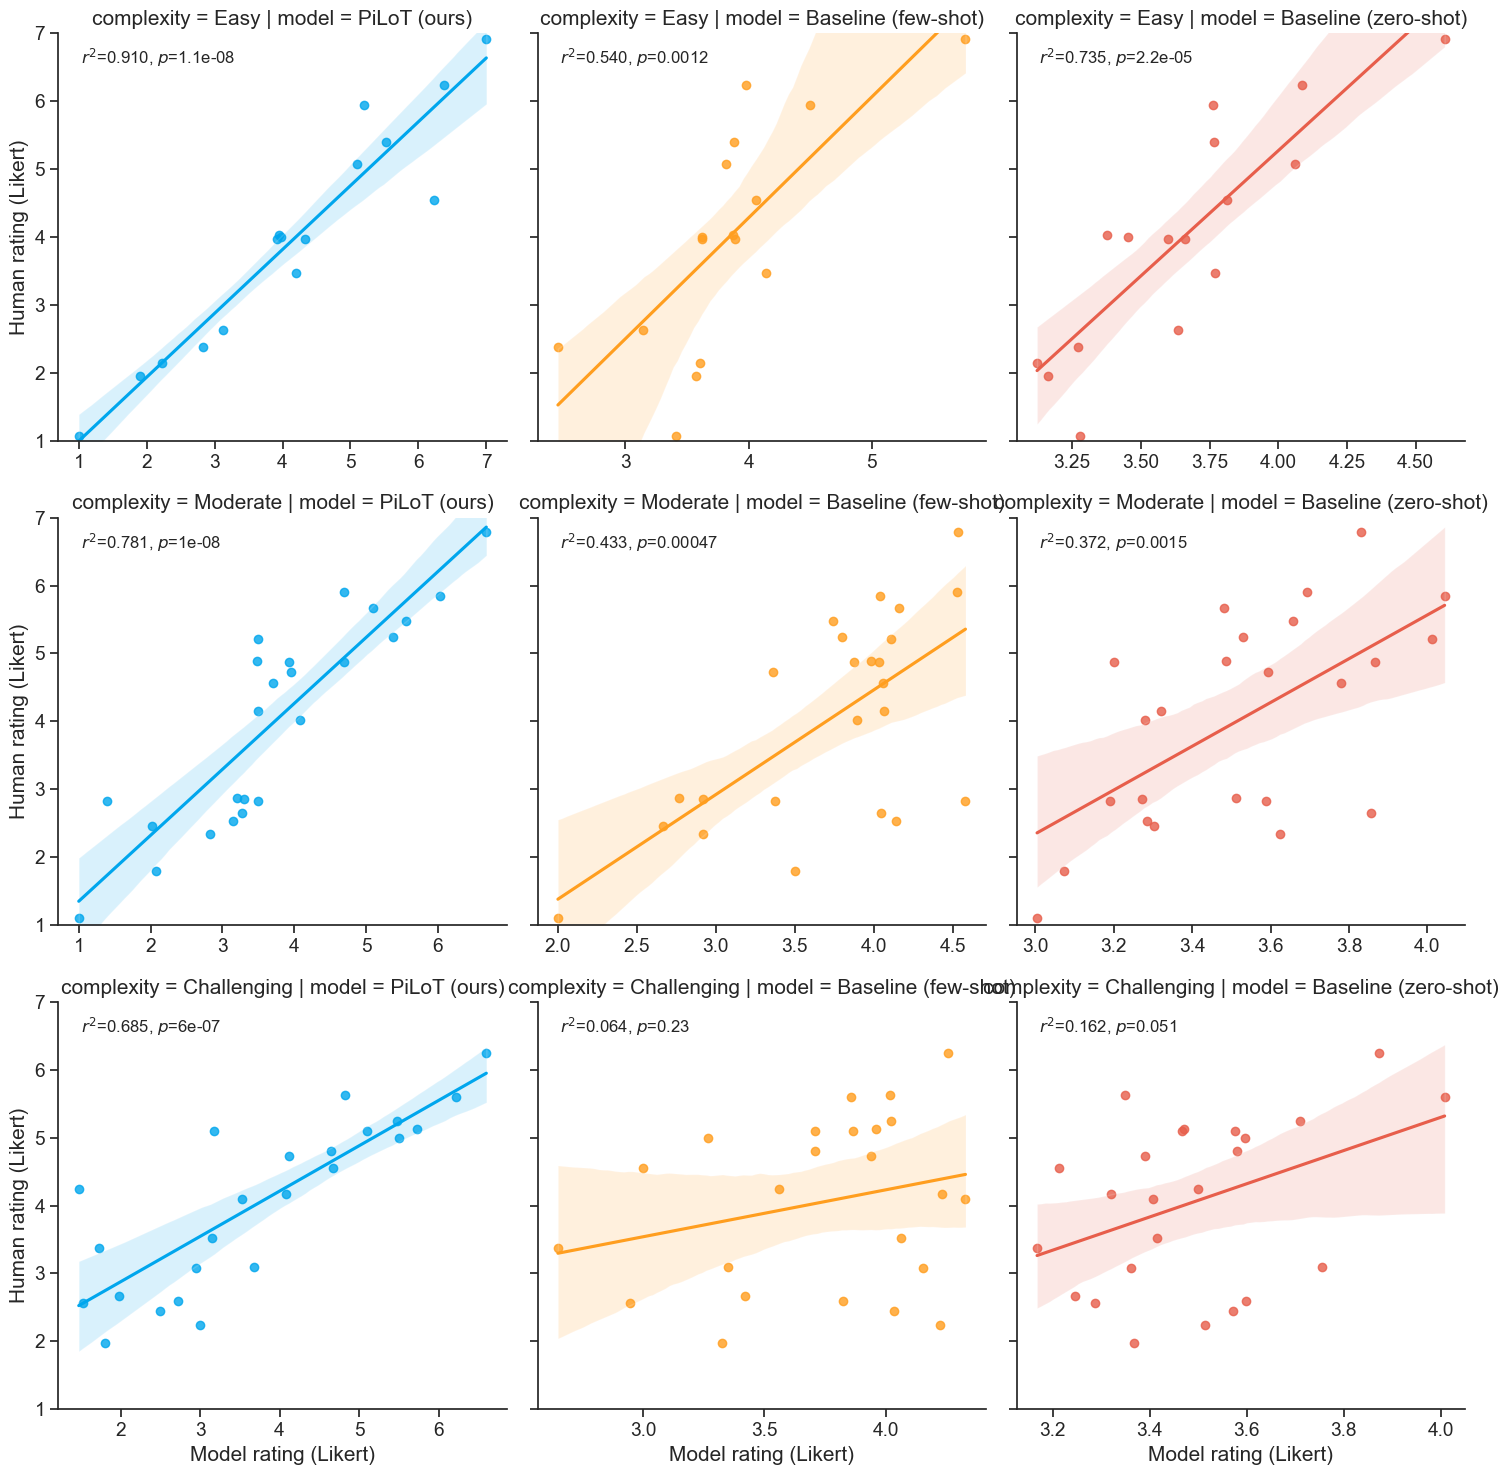

In [925]:
g = sns.lmplot(data=df_facets, x="Model rating (Likert)", y="Human rating (Likert)", row="complexity", col="model", sharex=False, sharey=True, hue="model")
g.set(ylim=(1, 7))

def annotate(data, **kws):
    r, p = pearsonr(data['Model rating (Likert)'].tolist(), data['Human rating (Likert)'].tolist())
    ax = plt.gca()
    ax.text(.05, 0.925, r'$r^2$={:.3f}, $p$={:.2g}'.format(r ** 2, p),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
plt.savefig("model_comparison_by_complexity.png", dpi=300, bbox_inches="tight")

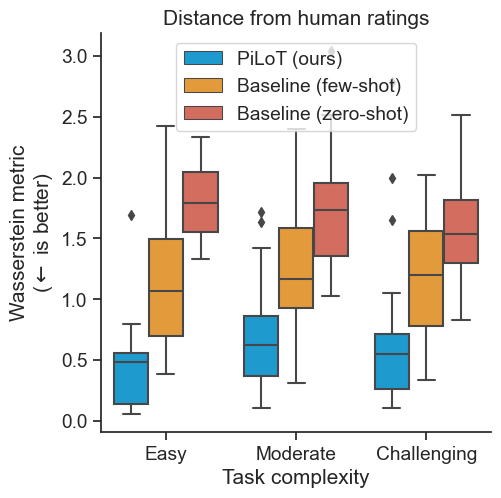

In [953]:
sns.catplot(data=df_facets, x="complexity", y="wasserstein", hue="model", kind="box", legend_out=False, aspect=1.0)
plt.title("Distance from human ratings")
plt.xlabel("Task complexity")
plt.ylabel("Wasserstein metric\n" + r"($\leftarrow$ is better)")

# Remove legend title
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

plt.savefig("wasserstein_comparison_boxplot.png", dpi=300, bbox_inches="tight")

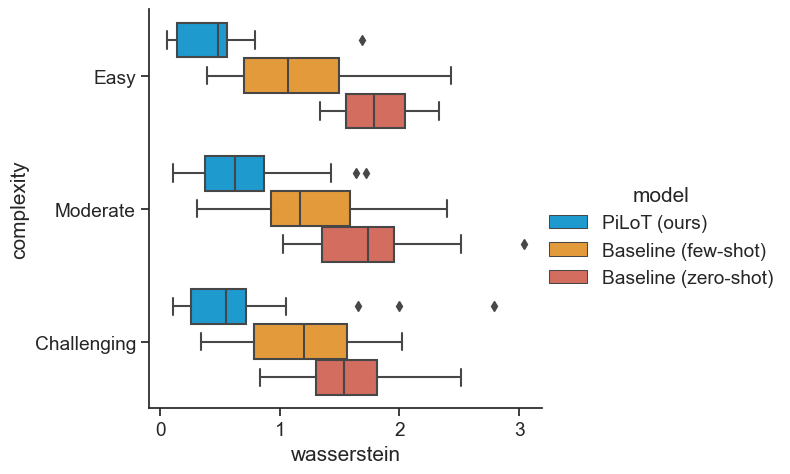

In [927]:
sns.catplot(data=df_facets, x="wasserstein", y="complexity", hue="model", kind="box", aspect=1.25)


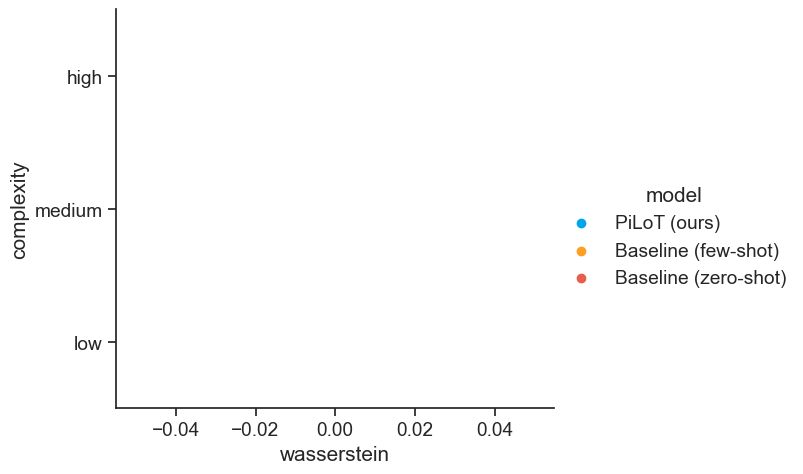

In [928]:
sns.catplot(data=df_facets, x="wasserstein", y="complexity", hue="model", kind="swarm", order=["high", "medium", "low"], aspect=1.25)

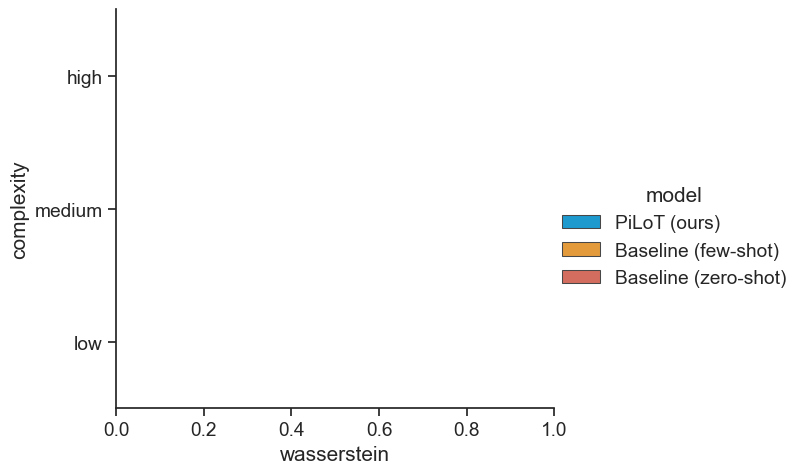

In [929]:
sns.catplot(data=df_facets, x="wasserstein", y="complexity", hue="model", kind="violin", order=["high", "medium", "low"], aspect=1.25)

In [930]:
df_facets.groupby(["model", "complexity"]).mean("wasserstein")

Model rating (Likert)  \
model                complexity                           
Baseline (few-shot)  Challenging               3.738563   
                     Easy                      3.832964   
                     Moderate                  3.714159   
Baseline (zero-shot) Challenging               3.489218   
                     Easy                      3.651401   
                     Moderate                  3.520238   
PiLoT (ours)         Challenging               3.757292   
                     Easy                      4.179688   
                     Moderate                  3.750000   

                                  Human rating (Likert)  Human error  \
model                complexity                                        
Baseline (few-shot)  Challenging               4.051277     0.172534   
                     Easy                      3.984939     0.102697   
                     Moderate                  4.019794     0.141968   
Baseline (zero-shot) Challenging               4.051277     0.172534   
                     Easy                      3.984939     0.102697   
                     Moderate                  4.019794     0.141968   
PiLoT (ours)         Challenging               4.051277     0.172534   
                     Easy                      3.984939     0.102697   
                     Moderate                  4.019794     0.141968   

                                  wasserstein  
model                complexity                
Baseline (few-shot)  Challenging     1.192382  
                     Easy            1.166143  
                     Moderate        1.222726  
Baseline (zero-shot) Challenging     1.551299  
                     Easy            1.815303  
                     Moderate        1.754614  
PiLoT (ours)         Challenging     0.670019  
                     Easy            0.448296  
                     Moderate        0.690825

In [931]:
df_facets.groupby(["model", "complexity"])["Model rating (Likert)", "Human rating (Likert)"].corr()

/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_24693/2640445311.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_facets.groupby(["model", "complexity"])["Model rating (Likert)", "Human rating (Likert)"].corr()


Model rating (Likert)  \
model                complexity                                                 
Baseline (few-shot)  Challenging Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.253052   
                     Easy        Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.734735   
                     Moderate    Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.658131   
Baseline (zero-shot) Challenging Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.402271   
                     Easy        Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.857283   
                     Moderate    Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.610071   
PiLoT (ours)         Challenging Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.827728   
                     Easy        Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.953806   
                     Moderate    Model rating (Likert)               1.000000   
                                 Human rating (Likert)               0.883769   

                                                        Human rating (Likert)  
model                complexity                                                
Baseline (few-shot)  Challenging Model rating (Likert)               0.253052  
                                 Human rating (Likert)               1.000000  
                     Easy        Model rating (Likert)               0.734735  
                                 Human rating (Likert)               1.000000  
                     Moderate    Model rating (Likert)               0.658131  
                                 Human rating (Likert)               1.000000  
Baseline (zero-shot) Challenging Model rating (Likert)               0.402271  
                                 Human rating (Likert)               1.000000  
                     Easy        Model rating (Likert)               0.857283  
                                 Human rating (Likert)               1.000000  
                     Moderate    Model rating (Likert)               0.610071  
                                 Human rating (Likert)               1.000000  
PiLoT (ours)         Challenging Model rating (Likert)               0.827728  
                                 Human rating (Likert)               1.000000  
                     Easy        Model rating (Likert)               0.953806  
                                 Human rating (Likert)               1.000000  
                     Moderate    Model rating (Likert)               0.883769  
                                 Human rating (Likert)               1.000000

## BIG TABLE

In [932]:
df_facets

,model,Model rating (Likert),Human rating (Likert),Human error,complexity,number,location,quant_or_neg,vague_adj,wasserstein
task_id,,,,,,,,,,
1,PiLoT (ours),1.900000,1.952381,0.117822,Easy,1,,,,0.054422
1,Baseline (few-shot),3.576526,1.952381,0.117822,Easy,1,,,,1.749028
1,Baseline (zero-shot),3.162319,1.952381,0.117822,Easy,1,,,,1.662859
2,PiLoT (ours),5.525000,5.400000,0.133012,Easy,1,,,,0.182653
2,Baseline (few-shot),3.885004,5.400000,0.133012,Easy,1,,,,1.535303
...,...,...,...,...,...,...,...,...,...,...
63,Baseline (few-shot),4.021730,5.250000,0.166987,Challenging,1,1,2,1,1.396941
63,Baseline (zero-shot),3.709788,5.250000,0.166987,Challenging,1,1,2,1,1.833034
64,PiLoT (ours),2.725000,2.595238,0.152637,Challenging,1,1,2,1,0.253333


In [933]:
facet_to_fancy = {
    "number": "Number",
    "location": "Spatial",
    "quant_or_neg": "Quantifier/Negation",
    "vague_adj": "Graded Adjective",
}

def pval_to_asterisk(pval):
    if pval <= 0.001:
        return "***"
    elif pval <= 0.01:
        return "**"
    elif pval <= 0.05:
        return "*"
    else:
        return "N.S."

def compute_metrics(df_group, facet):
    data = []
    rho, pval = pearsonr(df_group["Model rating (Likert)"].tolist(), df_group["Human rating (Likert)"].tolist())
    
    wasserstein_mean = df_group["wasserstein"].mean()
    wasserstein_err = df_group["wasserstein"].sem()

    data.append({
        "model": model,
        "facet": facet,
        "metric": r"$R^2$",
        "value": f"{rho ** 2:.02}{pval_to_asterisk(pval)}",
    })
    data.append({
        "model": model,
        "facet": facet,
        "metric": "WD",
        "value": f"{wasserstein_mean:1.2f} (±{wasserstein_err:.01})",
    })
    return data


data = []

for model, df_group in df_facets.groupby("model", sort=False):

    data.extend(compute_metrics(df_group, "Overall"))

    for complexity, df_group_complexity in df_group.groupby("complexity", sort=False):
        data.extend(compute_metrics(df_group_complexity, complexity))
        
    for facet in ["number", "location", "quant_or_neg", "vague_adj"]:
        data.extend(compute_metrics(df_group[df_group[facet].astype(bool)], facet_to_fancy[facet]))
    
df_summary = pd.DataFrame(data)
df_summary

,model,facet,metric,value
0,PiLoT (ours),Overall,$R^2$,0.76***
1,PiLoT (ours),Overall,WD,0.62 (±0.07)
2,PiLoT (ours),Easy,$R^2$,0.91***
3,PiLoT (ours),Easy,WD,0.45 (±0.1)
4,PiLoT (ours),Moderate,$R^2$,0.78***
5,PiLoT (ours),Moderate,WD,0.69 (±0.09)
6,PiLoT (ours),Challenging,$R^2$,0.69***
7,PiLoT (ours),Challenging,WD,0.67 (±0.1)
8,PiLoT (ours),Number,$R^2$,0.76***
9,PiLoT (ours),Number,WD,0.57 (±0.08)


In [934]:
df_summary_out = pd.pivot(df_summary, index="model", columns=["facet", "metric"], values=["value"])
df_summary_out.index = df_summary_out.index.astype(model_order)
df_summary_out = df_summary_out.sort_index(ascending=False)
df_summary_out

value                                                \
facet                 Overall                   Easy               Moderate   
metric                  $R^2$            WD    $R^2$            WD    $R^2$   
model                                                                         
Baseline (zero-shot)   0.4***  1.69 (±0.05)  0.73***  1.82 (±0.08)   0.37**   
Baseline (few-shot)   0.34***  1.20 (±0.06)   0.54**   1.17 (±0.2)  0.43***   
PiLoT (ours)          0.76***  0.62 (±0.07)  0.91***   0.45 (±0.1)  0.78***   

                                                                       \
facet                              Challenging                 Number   
metric                          WD       $R^2$            WD    $R^2$   
model                                                                   
Baseline (zero-shot)   1.75 (±0.1)    0.16N.S.  1.55 (±0.09)   0.27**   
Baseline (few-shot)    1.22 (±0.1)   0.064N.S.   1.19 (±0.1)    0.15*   
PiLoT (ours)          0.69 (±0.09)     0.69***   0.67 (±0.1)  0.76***   

                                                                               \
facet                               Spatial               Quantifier/Negation   
metric                          WD    $R^2$            WD               $R^2$   
model                                                                           
Baseline (zero-shot)  1.63 (±0.06)   0.23**  1.67 (±0.08)             0.47***   
Baseline (few-shot)   1.19 (±0.07)    0.17*  1.21 (±0.08)             0.36***   
PiLoT (ours)          0.57 (±0.08)  0.67***   0.74 (±0.1)             0.76***   

                                                                   
facet                              Graded Adjective                
metric                          WD            $R^2$            WD  
model                                                              
Baseline (zero-shot)  1.70 (±0.08)            0.23*  1.63 (±0.08)  
Baseline (few-shot)   1.28 (±0.08)            0.3**  1.14 (±0.09)  
PiLoT (ours)           0.67 (±0.1)           0.8***  0.54 (±0.07)

In [935]:
df_summary_out.style.to_latex("summary_table.tex")

In [936]:
df_simulator_mean = df_simulator.groupby("task_id").mean("likert")
df_human_mean = df_human.groupby("task_id").mean("likert_human")
df_comparison = df_simulator_mean.join(df_human_mean[["likert_human"]], how="inner")
df_comparison.to_csv("comparison_simulator_human.csv")

## EXPORT

In [937]:
pd.concat([df_human_tall, df_simulator_tall]).reset_index(drop=True).to_csv("comparison_human_simulator.csv")

In [938]:
rho, pval = pearsonr(df_comparison["likert_simulator"].tolist(), df_comparison["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

KeyError: 'likert_simulator'

In [ ]:
sns.regplot(data=df_comparison, x="likert_simulator", y="likert_human")
plt.xlabel("Neurosymbolic LoT physics simulator (Likert)")
plt.ylabel("Human participants (Likert)")
plt.title(fr"Model vs. human ratings ($r^2={(rho ** 2):.04f}$)")
plt.savefig(f"physlang_model_human_results.png", dpi=300)

In [ ]:
sns.jointplot(data=df_comparison, x="likert_simulator", y="likert_human", kind="reg")

In [ ]:
def transform_probs_to_likert(probs):
    return np.dot(probs, np.array([1, 2, 3, 4, 5, 6, 7]))

df_baseline_zeroshot_tall["likert_baseline_zeroshot"] = df_baseline_zeroshot_tall["probs"].apply(transform_probs_to_likert)
df_baseline_fewshot_tall["likert_baseline_fewshot"] = df_baseline_fewshot_tall["probs"].apply(transform_probs_to_likert)

In [ ]:
df_baseline_zeroshot_tall

In [ ]:
df_baseline_zeroshot_tall["likert_baseline_zeroshot"].hist()

In [ ]:
df_baseline_fewshot_tall["likert_baseline_fewshot"].hist()

In [ ]:
df_comparison_baseline_zeroshot = df_baseline_zeroshot_tall.join(df_human_mean[["likert_human"]], how="inner")
sns.regplot(data=df_comparison_baseline_zeroshot, x="likert_baseline_zeroshot", y="likert_human")

In [ ]:
rho, pval = pearsonr(df_comparison_baseline_zeroshot["likert_baseline_zeroshot"].tolist(), df_comparison_baseline_zeroshot["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

In [ ]:
df_comparison_baseline_fewshot = df_baseline_fewshot_tall.join(df_human_mean[["likert_human"]], how="inner")
sns.regplot(data=df_comparison_baseline_fewshot, x="likert_baseline_fewshot", y="likert_human")

In [ ]:
rho, pval = pearsonr(df_comparison_baseline_fewshot["likert_baseline_fewshot"].tolist(), df_comparison_baseline_fewshot["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

In [ ]:
sns.regplot(data=df_comparison, x="likert_simulator", y="likert_human")
sns.regplot(data=df_comparison_baseline_zeroshot, x="likert_baseline_zeroshot", y="likert_human")
sns.regplot(data=df_comparison_baseline_fewshot, x="likert_baseline_fewshot", y="likert_human")

In [ ]:
def tall_to_wide(df, likert_col: str = "likert"):

    data = []
    for task_id, df_group in df.groupby("task_id"):

        value_counts = {likert_value: 0.0 for likert_value in [1, 2, 3, 4, 5, 6, 7]}
        for likert_value, weight in df_group[likert_col].value_counts(normalize=True).sort_index().items():
            value_counts[likert_value] = weight
        likert_weights = list(value_counts.values())

        data.append({
            "task_id": task_id,
            "likert_weights": likert_weights,
        })

    df_wide = pd.DataFrame(data)
    assert np.allclose(df_wide["likert_weights"].apply(sum), 1.0)
    return df_wide

In [ ]:
df_human_wide = tall_to_wide(df_human, likert_col="likert_human")
df_human_wide["source"] = "human"
df_human_wide

In [ ]:
df_simulator_wide = tall_to_wide(df_simulator, likert_col="likert_simulator")
df_simulator_wide["source"] = "simulator"
df_simulator_wide

In [ ]:
df_baseline_zeroshot_tall_wide = df_baseline_zeroshot_tall[["probs"]].rename({"probs": "likert_weights"}, axis="columns").reset_index()
assert np.allclose(df_baseline_zeroshot_tall_wide["likert_weights"].apply(sum), 1.0)
df_baseline_zeroshot_tall_wide["source"] = "baseline_zeroshot"
df_baseline_zeroshot_tall_wide

In [ ]:
df_baseline_fewshot_tall_wide = df_baseline_fewshot_tall[["probs"]].rename({"probs": "likert_weights"}, axis="columns").reset_index()
assert np.allclose(df_baseline_fewshot_tall_wide["likert_weights"].apply(sum), 1.0)
df_baseline_fewshot_tall_wide["source"] = "baseline_fewshot"
df_baseline_fewshot_tall_wide

In [ ]:
df_comparison_wide = pd.concat([df_human_wide, df_simulator_wide, df_baseline_zeroshot_tall_wide, df_baseline_fewshot_tall_wide]).sort_values("task_id").reset_index(drop=True)
df_comparison_wide

In [ ]:
data = []

for task_id, df_group in df_comparison_wide.groupby("task_id"):
    
    likert = [1, 2, 3, 4, 5, 6, 7]
    
    likert_weights_human = df_group[df_group["source"] == "human"]["likert_weights"].item()
    likert_weights_simulator = df_group[df_group["source"] == "simulator"]["likert_weights"].item()
    likert_weights_baseline_zeroshot = df_group[df_group["source"] == "baseline_zeroshot"]["likert_weights"].item()
    likert_weights_baseline_fewshot = df_group[df_group["source"] == "baseline_fewshot"]["likert_weights"].item()
    
    wd_human_simulator = wasserstein_distance(likert, likert, likert_weights_human, likert_weights_simulator)
    wd_human_baseline_zeroshot = wasserstein_distance(likert, likert, likert_weights_human, likert_weights_baseline_zeroshot)
    wd_human_baseline_fewshot = wasserstein_distance(likert, likert, likert_weights_human, likert_weights_baseline_fewshot)
    
    data.append(
        {
            "task_id": task_id,
            "PhysLoT": wd_human_simulator,
            "Baseline (zero-shot)": wd_human_baseline_zeroshot,
            "Baseline (few-shot)": wd_human_baseline_fewshot,
        }
    )
    
df_wd = pd.DataFrame(data).set_index("task_id")

In [ ]:
sns.histplot(data=df_wd, stat="count", binwidth=0.25, kde=True)
plt.xlabel("Wasserstein distance")
plt.savefig("wasserstein_comparison.png", dpi=300)

In [ ]:
sns.kdeplot(data=df_wd)

In [ ]:
df_human_tall = df_human.drop(["run_id", "complexity", "group"], axis="columns").reset_index()
df_human_tall = df_human_tall.rename({"likert_human": "likert"}, axis="columns")
df_human_tall["source"] = "human"
df_human_tall

In [ ]:
df_simulator_tall = df_simulator.drop("example_answer", axis="columns").reset_index(drop=True)
df_simulator_tall = df_simulator_tall.rename({"likert_simulator": "likert"}, axis="columns")
df_simulator_tall["source"] = "simulator"
df_simulator_tall

In [ ]:
df_baseline_zeroshot_tall_tall = df_baseline_zeroshot_tall[["likert_baseline_zeroshot"]].reset_index()
df_baseline_zeroshot_tall_tall = df_baseline_zeroshot_tall_tall.rename({"likert_baseline_zeroshot": "likert"}, axis="columns")
df_baseline_zeroshot_tall_tall["source"] = "baseline_zeroshot"
df_baseline_zeroshot_tall_tall

In [ ]:
df_comparison_tall = pd.concat([df_human_tall, df_simulator_tall, df_baseline_zeroshot_tall_tall]).sort_values("task_id").reset_index(drop=True)
df_comparison_tall

In [ ]:
data = []

for task_id, df_group in df_comparison_tall.groupby("task_id"):
    
    likert_human = df_group[df_group["source"] == "human"]["likert"].tolist()
    likert_simulator = df_group[df_group["source"] == "simulator"]["likert"].tolist()
    likert_baseline_zeroshot = df_group[df_group["source"] == "baseline_zeroshot"]["likert"].tolist()
    
    wd_human_simulator = wasserstein_distance(likert_human, likert_simulator)
    wd_human_baseline_zeroshot = wasserstein_distance(likert_human, likert_baseline_zeroshot)
    
    data.append(
        {
            "task_id": task_id,
            "wd_human_simulator": wd_human_simulator,
            "wd_human_baseline_zeroshot": wd_human_baseline_zeroshot,
        }
    )
    
df_wd = pd.DataFrame(data).set_index("task_id")